In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import cv2
from scipy.spatial.distance import euclidean
from pathlib import Path
from tqdm import trange
from typing import Tuple
from dm_control import mjcf

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena.mujoco_arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters
from flygym.util.turning_controller import TurningController

In [2]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (300, 300),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 1,
        init_ball_pos: Tuple[float, float] = (5, 0),
        move_speed: float = 8,
        move_direction: str = "right",
    ):
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        heading_vec = np.array([1, 2 * np.cos(self.curr_time * 3) * self.y_mult])
        self.ball_pos[:2] += self.move_speed * (heading_vec / np.linalg.norm(heading_vec)) * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos

In [3]:
class VisualTaxis(TurningController):
    def __init__(self, obj_threshold=50, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs)

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)
    
    def step(self, control_signal):
        for _ in range(self.num_substeps):
            obs, _, _, _, _ = super().step(control_signal)
            render_res = super().render()
            if render_res is not None:
                self.visual_inputs_hist.append(self.curr_visual_input.copy())
        visual_features = self._get_visual_features()
        return visual_features, 0, False, False, {}
    
    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= (config.num_ommatidia_per_eye / 2)  # normalize area
        return features.flatten()
    
    def reset(self, seed=None):
        super().reset()
        return self._get_visual_features(), {}

In [4]:
arena = MovingObjArena()
sim_params = MuJoCoParameters(
    render_camera="birdeye_cam",
    render_fps=30,
    render_playspeed=0.5,
    enable_adhesion=True,
    enable_vision=True,
)
sim = VisualTaxis(sim_params=sim_params, arena=arena)

In [5]:
def calc_ipsilateral_speed(deviation, is_found):
    if not is_found:
        return 1.0
    else:
        return np.clip(1 - deviation * 3, 0.2, 1.0)

In [6]:
obj_threshold = 50
decision_interval = 0.05

num_substeps = int(decision_interval / sim_params.timestep)

obs_hist = []
deviations_hist = []
control_signal_hist = []
raw_visual_hist = []

obs, _ = sim.reset()
for i in trange(100):
    left_deviation = 1 - obs[1]
    right_deviation = obs[4]
    left_found = obs[2] > 0.01
    right_found = obs[5] > 0.01
    if not left_found:
        left_deviation = np.nan
    if not right_found:
        right_deviation = np.nan
    control_signal = np.array(
        [
            calc_ipsilateral_speed(left_deviation, left_found),
            calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    obs, _, _, _, _ = sim.step(control_signal)
    obs_hist.append(obs)
    raw_visual_hist.append(sim.curr_visual_input.copy())
    deviations_hist.append([left_deviation, right_deviation])
    control_signal_hist.append(control_signal)

100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


In [7]:
def add_insets(viz_frame, visual_input):
    img_l = vision.hex_pxls_to_human_readable(visual_input[0, :, :]).astype(np.uint8)
    img_r = vision.hex_pxls_to_human_readable(visual_input[1, :, :]).astype(np.uint8)
    inset_size = (np.array(img_l.shape) * 0.3).astype(np.uint16)

    img_l = cv2.resize(img_l, inset_size[::-1])
    img_r = cv2.resize(img_r, inset_size[::-1])
    mask = cv2.resize((vision.ommatidia_id_map == 0).astype(np.uint8), inset_size[::-1])
    mask = mask == 0

    x_start = viz_frame.shape[1] - inset_size[1] * 2 - 10
    y_start = 5

    viz_frame = viz_frame.copy()
    viz_frame[: inset_size[0] + 10, x_start - 5:, :] = 30

    _x0 = x_start
    _x1 = x_start + inset_size[1]
    _y0 = y_start
    _y1 = y_start + inset_size[0]
    img_l_rgb = np.stack([img_l, img_l, img_l], axis=-1)
    viz_frame[_y0:_y1, _x0:_x1, :][mask] = img_l_rgb[mask]

    _x0 = x_start + inset_size[1] + 5
    _x1 = x_start + inset_size[1] * 2 + 5
    _y0 = y_start
    _y1 = y_start + inset_size[0]
    img_r_rgb = np.stack([img_r, img_r, img_r], axis=-1)
    viz_frame[_y0:_y1, _x0:_x1, :][mask] = img_r_rgb[mask]

    cv2.putText(
        viz_frame,
        f"L",
        org=(x_start, 27),
        fontFace=cv2.FONT_HERSHEY_DUPLEX,
        fontScale=0.8,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA,
        thickness=1,
    )
    cv2.putText(
        viz_frame,
        f"R",
        org=(viz_frame.shape[1] - 22, 27),
        fontFace=cv2.FONT_HERSHEY_DUPLEX,
        fontScale=0.8,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA,
        thickness=1,
    )

    return viz_frame

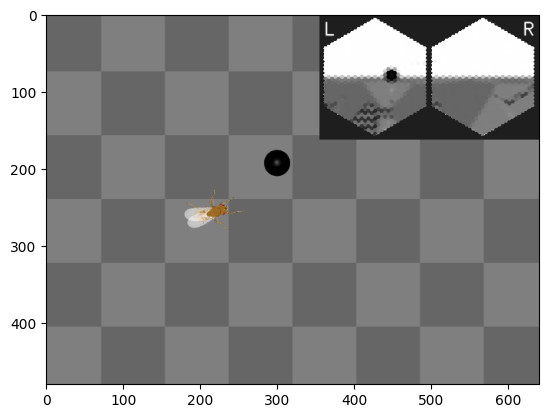

In [8]:
plt.imshow(add_insets(sim._frames[100], sim.visual_inputs_hist[100]))

In [9]:
stabilization_time = 0.05
num_stab_frames = int(np.ceil(stabilization_time / sim._eff_render_interval))

path = Path("outputs/visual_taxis.mp4")
path.parent.mkdir(parents=True, exist_ok=True)
with imageio.get_writer(path, fps=sim.sim_params.render_fps) as writer:
    for frame, visual_inputs in zip(sim._frames[num_stab_frames:], sim.visual_inputs_hist[num_stab_frames:]):
        frame = add_insets(frame, visual_inputs)
        writer.append_data(frame)

In [18]:
individual_frames_dir = Path("outputs/individual_frames")
individual_frames_dir.mkdir(parents=True, exist_ok=True)

snapshot_interval_frames = 30

snapshots = np.array(
    [sim._frames[i] for i in range(0, len(sim._frames), snapshot_interval_frames)]
)
background = np.median(snapshots, axis=0)

for i in trange(0, snapshots.shape[0]):
    img = snapshots[i, :, :, :]
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    # break
    imageio.imwrite(
        individual_frames_dir / f"frame_{i}.png", img_alpha
    )

imageio.imwrite(individual_frames_dir / "background.png", background.astype(np.uint8))

100%|██████████| 10/10 [00:00<00:00, 25.94it/s]
